
 # JuliaHPC @ CERMICS
 
 ## Block 1: Writing good sequential code

Guillaume Dalle

2021/01/20

In [1]:
using BenchmarkTools
using LightGraphs, GraphPlot
using Profile, ProfileSVG
using ProgressMeter
using Random

# A. Julia basics

## Learning Julia

The Julia website has a great list of resources for beginners at https://julialang.org/learning/. Naturally, the primary source of knowledge is the Julia manual (https://docs.julialang.org/en/v1/). 

If you just need a quick refresher about syntax, https://juliadocs.github.io/Julia-Cheat-Sheet/ is the place to go.

In addition, we offer two handmade tutorials prepared by CERMICS students:
- https://github.com/gdalle/IntroJulia
- https://github.com/mfherbst/course_julia_day

If you want to go further, here is a list of quality books and tutorials:
- https://en.wikibooks.org/wiki/Introducing_Julia
- https://benlauwens.github.io/ThinkJulia.jl/latest/book.html
- https://techytok.com/from-zero-to-julia/
- https://ucidatascienceinitiative.github.io/IntroToJulia/

## Good practices

Here are some pieces of advice to make your Julia coding sessions easier.

### Workflow

When coding in Julia, you want to select a comfortable IDE. Safe choices include:
- Atom (https://atom.io/) with the Juno package (https://junolab.org/)
- VSCode (https://code.visualstudio.com/) with the Julia for VSCode package (https://www.julia-vscode.org/)
- Jupyterlab (http://jupyterlab.io) is getting better and better these days, looking more and more like a full browser-based IDE

Some workflow tips can be found on https://docs.julialang.org/en/v1/manual/workflow-tips/.

### Documentation

If you are courageous enough to write documentation (which you should be), the best place to put it is next to your code using docstrings. Julia docstrings are basically Markdown, see https://docs.julialang.org/en/v1/manual/documentation/ for a reference.

If you want to automatically generate a nice HTML documentation website, using 
https://github.com/JuliaDocs/Documenter.jl is the way to go.

### Unit testing

The nice thing about `Documenter.jl` is that is also enables unit testing from within the documentation itself. Inside a docstring, you can put examples of REPL input and expected output, which will be run again and checked for correctness every time the documentation is updated. These code examples are called doctests.

### Style

Julia has no universally agreed-upon style guide like Python. The main guidelines can be found at https://docs.julialang.org/en/v1/manual/style-guide/.

For an exhaustive style reference, have a look at the unofficial BlueStyle https://github.com/invenia/BlueStyle.

### Mathematical code

Julia supports unicode input (https://docs.julialang.org/en/v1/manual/unicode-input/), which include a large range of LateX symbols, indices and stuff like that. Don't hesitate to use it to make your code clearer.

In [2]:
√π

1.7724538509055159

## Getting help

The Julia community is very active and welcoming, so don't hesitate to ask for help in the following venues (by order of priority):
- a quick Google search
- the Julia Slack https://julialang.org/slack/
- the Julia discourse forum https://discourse.julialang.org/
- a specific package's GitHub issues

### Reading new code

When you dive into a new library, things can get pretty scary pretty fast. Fortunately, Julia has some built-in tools to help you:
- typing `?` before an object in the REPL displays its docstring
- `methods(func)` lists the methods associated with `func`
- `methodswith(typ)` lists the methods applying to type `typ`

### Discovering packages

Before coding something, you want to make sure that someone else hasn't already coded it better and faster than you. Since Julia package names are sometimes obscure, you may need to search for packages on a dedicated database: that's what https://juliaobserver.com/ and https://juliahub.com/ui/Home are here for.

In addition, Julia packages are often gathered into GitHub "groups", which are listed here: https://julialang.org/community/organizations/.

# B. Measuring code performance

## Running example: shortest paths in graphs

Let $G = (V, E, d)$ be an undirected weighted graph, and $s, t$ be two vertices. Computing a shortest $s-t$ path in $G$ can be done using Dynamic Programming.

If $c(v, k)$ denotes the cost of a shortest $s-v$ path using $k$ edges, then:

\begin{align}
    c(v, 0) & = \begin{cases} 0 & \text{if $v = s$} \\ +\infty & \text{otherwise} \end{cases} \\
    c(v, k+1) & = \min \{c(u, k) + d_{uv} ~|~ u \in \mathcal{N}(v)\}
\end{align}

And a shortest path has length at most $n-1$, so we want to compute $$\min\{c(t, k) ~|~ k \in [0,n-1]\}$$

In [3]:
function bellmanford1(G; s = 1, t = nv(G), d = ones(nv(G), nv(G)))
    n = nv(G)
    c = []
    c1 = []
    for v = 1:n
        c1v = v == s ? 0 : Inf
        push!(c1, c1v)
    end
    push!(c, c1)
    for k = 2:n
        ck = []
        for v = 1:n
            if length(neighbors(G, v)) > 0
                ckv = minimum([c[k-1][u] + d[u, v] for u in neighbors(G, v)])
            else
                ckv = Inf
            end
            push!(ck, ckv)
        end
        push!(c, ck)
    end
    return minimum([c[k][t] for k = 1:n])
end 

bellmanford1 (generic function with 1 method)

In [4]:
function bellmanford2(G; s = 1, t = nv(G), d = ones(nv(G), nv(G)))
    n = nv(G)
    c = fill(Inf, n, n)
    for v = 1:n
        c[v, 1] = v == s ? 0. : Inf
    end
    for k = 2:n
        for v = 1:n
            if length(neighbors(G, v)) > 0
                c[v, k] = minimum(c[u, k-1] + d[u, v] for u in neighbors(G, v))
            else
                c[v, k] = Inf
            end
        end
    end
    return minimum(c[t, k] for k = 1:n)
end 

bellmanford2 (generic function with 1 method)

In [5]:
G = erdos_renyi(10, 0.2)
println("G is a $G")
println("Result of bellmanford1(G): $(bellmanford1(G))")
println("Result of bellmanford2(G): $(bellmanford2(G))")

G is a {10, 9} undirected simple Int64 graph
Result of bellmanford1(G): 1.0
Result of bellmanford2(G): 1.0


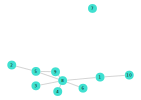

In [6]:
gplot(G, nodelabel=1:nv(G))

### Monitoring tools

- https://github.com/timholy/ProgressMeter.jl

In [7]:
@showprogress "A hundred naps : " for i = 1:100
    sleep(0.05)
end

A hundred naps : 100%|██████████████████████████████████| Time: 0:00:05


### Benchmarking tools

- `@time` macro for computation time and memory use
- `@timed` to store the results
- `@benchmark` macro from package https://github.com/JuliaCI/BenchmarkTools.jl for multiple runs

In [8]:
@time bellmanford1(G);

  0.000074 seconds (625 allocations: 23.188 KiB)


In [9]:
@time bellmanford2(G);

  0.000011 seconds (3 allocations: 1.766 KiB)


In [10]:
@benchmark bellmanford1(G)

BenchmarkTools.Trial: 
  memory estimate:  23.19 KiB
  allocs estimate:  625
  --------------
  minimum time:     21.491 μs (0.00% GC)
  median time:      22.611 μs (0.00% GC)
  mean time:        31.686 μs (9.14% GC)
  maximum time:     10.173 ms (99.33% GC)
  --------------
  samples:          10000
  evals/sample:     1

In [11]:
@benchmark bellmanford2(G)

BenchmarkTools.Trial: 
  memory estimate:  1.77 KiB
  allocs estimate:  3
  --------------
  minimum time:     913.556 ns (0.00% GC)
  median time:      927.833 ns (0.00% GC)
  mean time:        1.009 μs (3.46% GC)
  maximum time:     30.049 μs (96.60% GC)
  --------------
  samples:          10000
  evals/sample:     36

### Profiling tools

- https://docs.julialang.org/en/v1/manual/profile/
- https://github.com/timholy/ProfileView.jl
- https://github.com/kimikage/ProfileSVG.jl

In [12]:
G = erdos_renyi(1000, 0.01)

{1000, 4970} undirected simple Int64 graph

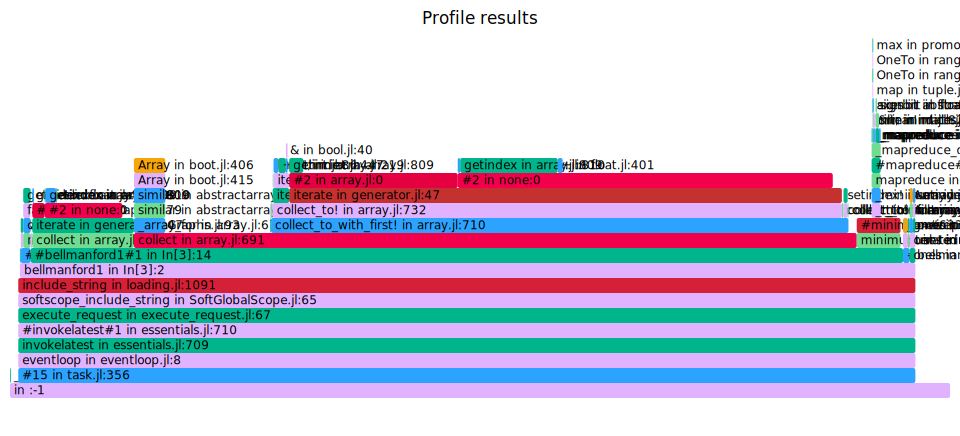

In [13]:
@profview bellmanford1(G)

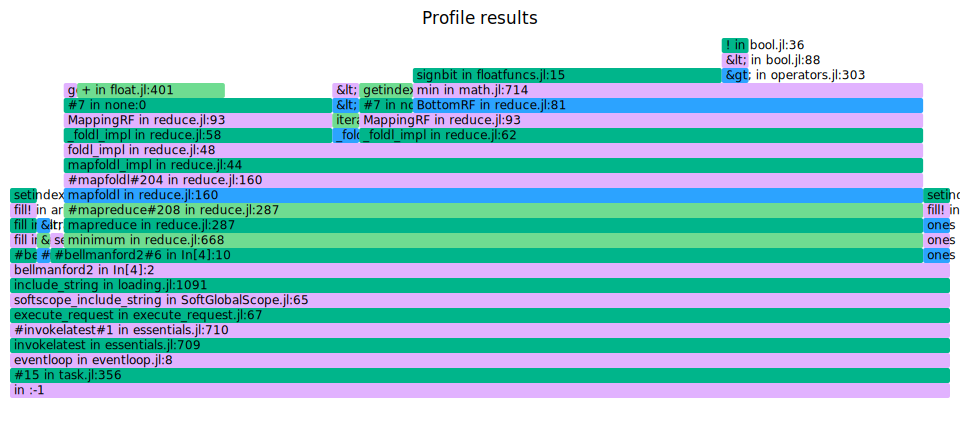

In [14]:
@profview bellmanford2(G)

### Bonus: built-in IDE tools

Among the nice features of Juno, you will find a built-in profiler and a progress meter : https://docs.junolab.org/latest/man/juno_frontend/. The profiler displays a specific color for function calls that are either dynamically dispatched or require a lot of garbage compiler action.

# C. Improving code performance

The primary source for this section is the Julia language manual: https://docs.julialang.org/en/v1/manual/performance-tips/.

Here are some secondary sources:
- www.stochasticlifestyle.com/7-julia-gotchas-handle/

## General advice

- Premature optimization is the root of all evil
- Never optimize before profiling, you could end up optimizing the wrong part of the code
- Use https://github.com/JunoLab/Traceur.jl to find inefficiencies in your code

## Memory allocations

- Prefer in-place operations
- Pre-allocate output
- Beware of vectorized operations

## Typing

- Write type-stable code (use `@code_warntype` to debug)
- Avoid abstract types as fields

## Multiple dispatch

- http://www.stochasticlifestyle.com/type-dispatch-design-post-object-oriented-programming-julia/

### Example: automatic differentiation